# Import packages

In [568]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score


variables à garder : 
['fam_ENQ', 'fl_fam_vam', 'niv_gravite_mtf_dne', 'fam_PCD',
       'Motif_Motif moyen', 'Motif_Motif tres mauvais',
       'Situation_fam_Mauvaise situation', 'Nature_op_Mauvaise nature']

# Import data

In [569]:
df = pd.read_csv('../data/df.csv',sep = ',')

In [570]:
df.columns

Index(['cd_op', 'EAD_1an_avant_def', 'dat_dec_echec', 'arrete', 'fl_fam_vam',
       'cum_frs_externes', 'CD_DNE_CHR_LGD_SAIN', 'niv_gravite_mtf_dne',
       'fam_ETH', 'fam_ENQ', 'cum_rec', 'fam_PCD', 'fl_prise_de_gar',
       'mt_dec_cum_IMP_tot', 'DET', 'Motif_Motif mauvais', 'Motif_Motif moyen',
       'Motif_Motif tres mauvais', 'Situation_fam_Bonne situation',
       'Situation_fam_Mauvaise situation', 'Nature_Bonne nature',
       'Nature_Mauvaise nature', 'Solution_echec_Bonne solution',
       'Solution_echec_Mauvaise solution', 'Nature_op_Bonne nature',
       'Nature_op_Mauvaise nature', 'MTF_Bon MTF', 'MTF_Mauvais MTF'],
      dtype='object')

In [571]:
df = df[['mt_dec_cum_IMP_tot','cd_op','arrete','DET']]

In [572]:
#df.drop(columns = ['MT_EAD_RESID', 'fl_prise_de_gar', 'fam_hyp', 'PTG'])

In [573]:
df.head()

,mt_dec_cum_IMP_tot,cd_op,arrete,DET
0,0.0,I860708600,2017-01-31,0
1,0.0,I950404213,2017-03-31,0
2,0.0,I950706618,2016-08-31,1
3,0.0,I950901248,2017-01-31,0
4,0.0,I960300578,2016-06-30,0


# Data treatment

In [574]:
df['arrete'] = pd.to_datetime(df['arrete'])

In [575]:
df_validation = df[df['arrete']>"2020-06-30"]

On split les données en un ensemble de train et un de test, toutes les données anterieures 2021 seront dans le train et le reste dans le test

In [576]:
data = df[df['arrete']<"2019-12-31"]

# Valeurs manquantes

In [577]:
data.isna().sum()

mt_dec_cum_IMP_tot    0
cd_op                 0
arrete                0
DET                   0
dtype: int64

In [578]:
df_validation.isna().sum()

mt_dec_cum_IMP_tot    0
cd_op                 0
arrete                0
DET                   0
dtype: int64

In [579]:
for col in data.select_dtypes(include = 'number').columns:
    valeur = data[col].median()
    data[col].fillna(valeur, inplace=True)
  
for col in df_validation.select_dtypes(include = 'number').columns:
    valeur = df_validation[col].median()
    df_validation[col].fillna(valeur, inplace=True)  


In [580]:
#valeur = data['PTG'].mode()
#data['PTG'].fillna(valeur.iloc[0], inplace=True)
#
#valeurval = df_validation['PTG'].mode()
#df_validation['PTG'].fillna(valeurval.iloc[0], inplace=True)


#valeur2 = data['niv_gravite_mtf_dne'].mode()
#data['niv_gravite_mtf_dne'].fillna(valeur2.iloc[0], inplace=True)

#valeur2val = df_validation['niv_gravite_mtf_dne'].mode()
#df_validation['niv_gravite_mtf_dne'].fillna(valeur2val.iloc[0], inplace=True)


# 01-Logit simple

In [581]:
data['DET'].value_counts()

DET
0    8936
1    5414
Name: count, dtype: int64

In [582]:
# Sélectionner les données
X_train = data.copy() # On drop les var qui ont trop de NaN
X_test = df_validation.copy()

X_train = X_train.select_dtypes(exclude = 'datetime')
X_train.dropna(inplace = True)

y_train = X_train['DET']


X_train.drop(columns = 'DET', inplace = True)

X_test = X_test.select_dtypes(exclude = 'datetime')
X_test.dropna(inplace = True)

y_test = X_test['DET']

X_test.drop(columns = 'DET', inplace = True)

Il faut drop une colonne par var cat pour eviter le probleme de multicolinearité

In [583]:
X_train.columns

Index(['mt_dec_cum_IMP_tot', 'cd_op'], dtype='object')

In [584]:
X_train.drop(columns = ['cd_op'], inplace = True)

X_test.drop(columns = ['cd_op'], inplace = True)

In [585]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


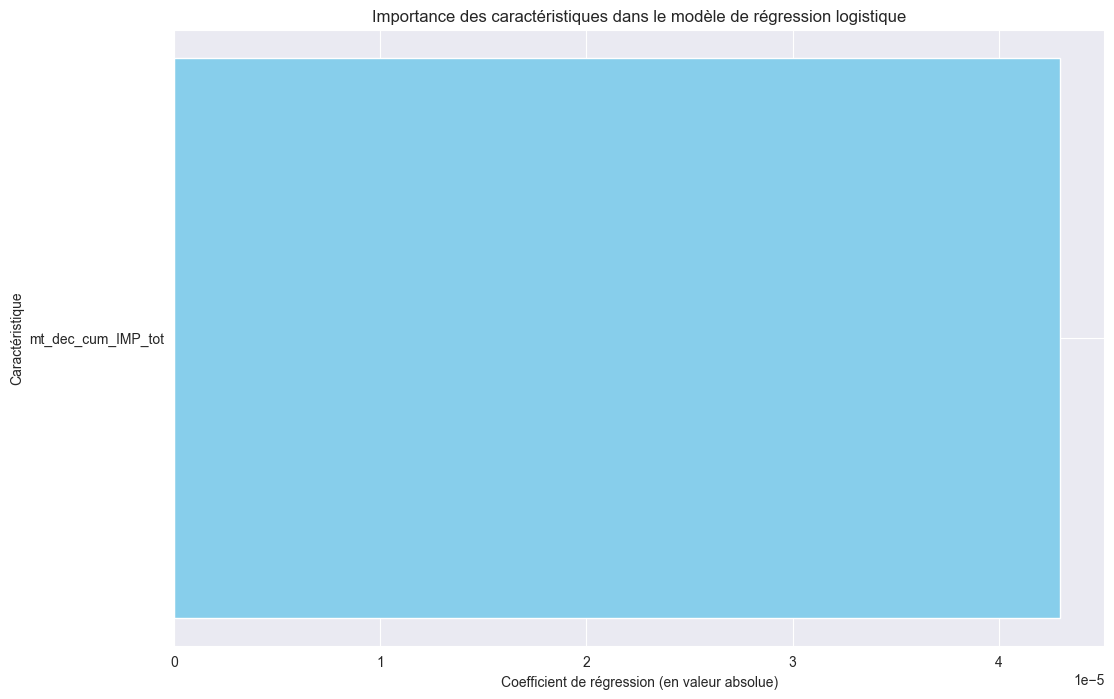

In [586]:
coefficients = model.coef_[0]

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression (en valeur absolue)')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()


In [587]:
feature_importance_df

,Feature,Coefficient,Abs_Coefficient
0,mt_dec_cum_IMP_tot,0.000043,0.000043


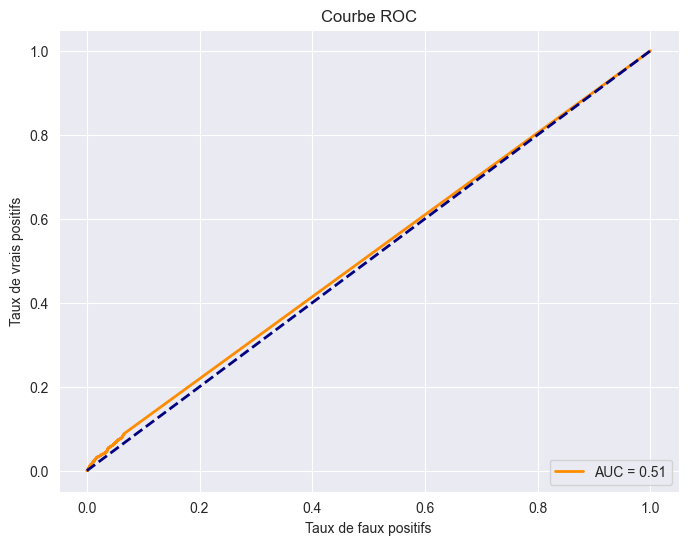

In [588]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Feature selection

In [589]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Créez un modèle logistique avec statsmodels
model = sm.Logit(y_train, X_train)

# Fit le modèle avec stepwise selection
result = model.fit(method='bfgs')  # Vous pouvez ajuster la méthode selon vos besoins

# Obtenez les prédictions sur l'ensemble de test
y_prob = result.predict(X_test)

# Convertissez les probabilités en prédictions binaires
y_pred = (y_prob >= 0.5).astype(int)

# Calculez l'AUC
auc = roc_auc_score(y_test, y_prob)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)

# Imprimez les résultats
print("AUC:", auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)


         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
AUC: 0.5
Confusion Matrix:
 [[   0 5186]
 [   0 1314]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5186
           1       0.20      1.00      0.34      1314

    accuracy                           0.20      6500
   macro avg       0.10      0.50      0.17      6500
weighted avg       0.04      0.20      0.07      6500


In [590]:
result.pvalues

const                 1.0
mt_dec_cum_IMP_tot    1.0
dtype: float64